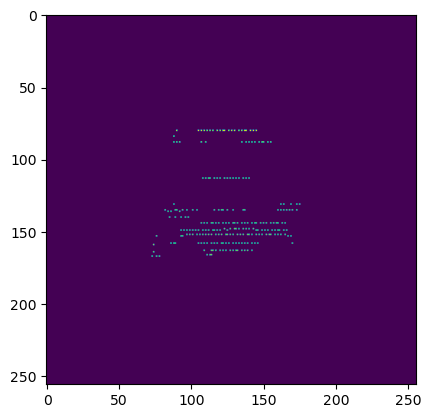

<Figure size 640x480 with 0 Axes>

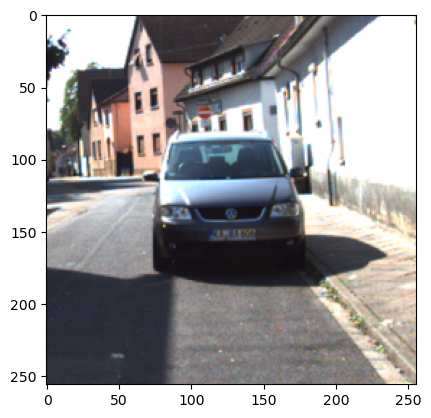

In [6]:
import os
import matplotlib.pyplot as plt
from skimage import io
import numpy as np

CALIB_DIR = './data/raw/calib/'

# https://github.com/azureology/kitti-velo2cam/blob/master/proj_velo2cam.py
def pcd_to_img(bin_pcd, index):
    FRAME = f'{"0"*(6 - len(str(index)))}{index}'
    # Load binary point cloud

    with open(f'{CALIB_DIR}{FRAME}.txt', 'r') as f:
        calib = f.readlines()

    P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
    R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

    # Reshape and drop reflection values
    points, reflectances = bin_pcd.reshape((-1, 4))[:, 0:3], bin_pcd.reshape((-1, 4))[:, 3]
    velo = np.insert(points,3,1,axis=1).T
    cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
    cam[:2] /= cam[2,:]
    #velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
    return cam

# test loading saved image and point cloud
file_id = 1
CARS_DIR = 'data/processed/'
img = io.imread(os.path.join(CARS_DIR, 'image_2/{0:06d}.png'.format(file_id)))
pc = np.fromfile(os.path.join(CARS_DIR, 'point_clouds/{0:06d}.bin'.format(file_id)), '<f4')  # little-endian float32

# get reflectances here too
cam = pcd_to_img(pc, file_id)
IMG_H = 374
IMG_W = 1238
    
[cH, cW] = np.load(os.path.join(CARS_DIR, 'centers/{0:06d}.npy'.format(file_id)))
u, v, z = cam
#plt.scatter([u], [v])
#U, V, Z = cam
u -= cW - 128
v -= cH - 128
proj_mat = np.zeros((IMG_H, IMG_W))
#print(u.shape)
for idx in range(u.shape[0]):
    row = int(v[idx])
    col = int(u[idx])
    proj_mat[row, col] = z[idx]
    
    
plt.figure()
plt.imshow(proj_mat[:256, :256])
plt.show()
plt.savefig('projected_cloud.png')

plt.figure()
plt.imshow(img)
plt.savefig('cropped_car.png')

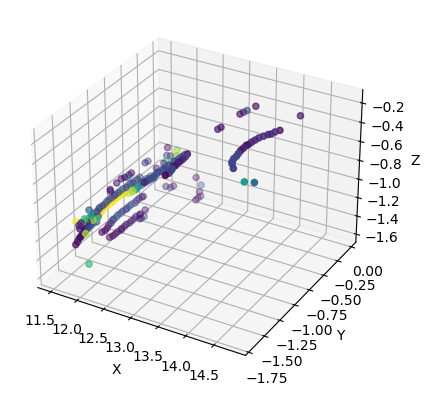

<Figure size 640x480 with 0 Axes>

In [11]:
pc = np.fromfile(os.path.join(CARS_DIR, 'point_clouds/{0:06d}.bin'.format(file_id)), '<f4')  # little-endian float32
pc = pc.reshape((-1, 4))
pcd_xyz = pc[:, :3]
pcd_refl = pc[:, 3]
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pcd_xyz[:,0], pcd_xyz[:,1], pcd_xyz[:,2], c=pcd_refl)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
plt.savefig('pcd_3d.png')